In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("yduan004/signatureSearch")

In [58]:
library(signatureSearch)


In [59]:
library(ExperimentHub); library(rhdf5)
eh <- ExperimentHub()
cmap <- eh[["EH3223"]]; cmap_expr <- eh[["EH3224"]]
lincs <- eh[["EH3226"]]; lincs_expr <- eh[["EH3227"]]


snapshotDate(): 2021-10-19

see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation

loading from cache

see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation

loading from cache

see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation

loading from cache

see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation

loading from cache



In [60]:
h5ls(lincs)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,assay,H5I_DATASET,FLOAT,12328 x 45956
1,/,colnames,H5I_DATASET,STRING,45956 x 1
2,/,rownames,H5I_DATASET,STRING,12328 x 1


1. `lincs` contains moderated z-scores from differential expression (DE) analysis of 12,328 genes from 8,140 compound treatments of 30 cell lines corresponding to a total of 45,956 signatures; 
2. `lincs_expr` contains gene expression intensity values from 5,925 compound treatments of 30 cell lines corresponding to a total of 38,824 signatures; 
3. cmap contains log2 fold changes of 12,437 genes from 1,281 compound treatments of 5 cell lines corresponding to a total of 3,478 signatures;
4. cmap_expr contains mean expression values from 1,309 drug treatments of 4 cell lines corresponding to a total of 3,587 signatures. 

To minimize redundancy in the `lincs` and `lincs_expr` databases, they were assembled from GESs corresponding to a compound dosage and treatment time of 10μ
M and 24h, respectively. If necessary one can create here easily database instances for all LINCS measurements. However, this will make the search results overwhelmingly complex which we wanted to avoid here

# Signature Searches (GESS)
Based on the data types represented in the query and database, they can be classified into set- and correlation-based methods (see Figure 1). The first 4 methods described below are set-based, whereas the last one is a correlation-based method. We refer to a search method as set-based if at least one of the two data components (query and/or database) is composed of an identifier set (e.g. gene labels) that may be ranked or unranked. In contrast to this, correlation-based methods require quantitative values, usually of the same type such as normalized intensities, for both the query and the database entries. An advantage of the set-based methods is that their queries can be the highest and lowest ranking gene sets derived from a genome-wide profiling technology that may differ from the one used to generate the reference database. However, the precision of correlation methods often outperforms set-based methods. On the other hand, due to the nature of the expected input, correlation-based methods are usually only an option when both the query and database entries are based on the same or at least comparable technologies. In other words, set-based methods are more technology agnostic than correlation-based methods, but may not provide the best precision performance.

## 1. Test Query and database
- use small toy to reduce the time taken
- a total of 100 GESs from human SKB (muscle) cells. Of the 100 GESs in this toy database, 95 were random sampled and 5 were cherry-picked.
- the latter 5 are GESs from HDAC inhibitor treatments including the known drugs: vorinostat, rhamnetin, trichostatin A, pyroxamide, and HC toxin
- to further reduce the size of the toy database, the number of its genes was reduced from 12328 genes to 5000 by random sampling.
- the query signature is vorinostat GES


In [5]:
db_path <- system.file('extdata', 'sample_db.h5', package = 'signatureSearch')

library(SummarizedExperiment); library(HDF5Array)
sample_db <- SummarizedExperiment(HDF5Array(db_path, name="assay"))
rownames(sample_db) <- HDF5Array(db_path, name="rownames")
colnames(sample_db) <- HDF5Array(db_path, name="colnames")
# get "vorinostat__SKB__trt_cp" signature drawn from toy database
query_mat <- as.matrix(assay(sample_db[,"vorinostat__SKB__trt_cp"]))
query = as.numeric(query_mat); names(query) = rownames(query_mat)
upset <- head(names(query[order(-query)]), 150)
head(upset)

Loading required package: DelayedArray

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand



Attaching package: ‘DelayedArray’


The following objects are masked from ‘package:base’:

    aperm, apply, rowsum, scale, sweep



Attaching package: ‘HDF5Array’


The following object is masked from ‘package:rhdf5’:

    h5ls




[1] "230"  "5357" "2015" "2542" "1759" "6195"

In [6]:
downset <- tail(names(query[order(-query)]), 150)
head(downset)

[1] "22864" "9338"  "54793" "10384" "27000" "10161"

# 2. CMAP Search Method
- Uses query the 2 label sets of the most up- and down-regulated genes from a genome-wide expression experiment, while the reference database is composed of rank transformed expression profiles (e.g. ranks of LFC or z-scores).

In [7]:
qsig_cmap <- qSig(query = list(upset=upset, downset=downset), 
                  gess_method="CMAP", refdb=db_path)

150 / 150 genes in up set share identifiers with reference database

150 / 150 genes in down set share identifiers with reference database



In [8]:
cmap <- gess_cmap(qSig=qsig_cmap, chunk_size = 5000, workers=1)
cmap

#
# gessResult object 
#
@result 
# A tibble: 100 × 10
   pert       PCID    cell  type  trend raw_score scaled_score N_upset N_downset
   <chr>      <chr>   <chr> <chr> <chr>     <dbl>        <dbl>   <int>     <int>
 1 vorinostat 5311    SKB   trt_… up        1.94         1         150       150
 2 rescinnam… 5280954 SKB   trt_… down     -0.295       -1         150       150
 3 zuclopent… 5311507 SKB   trt_… down     -0.287       -0.972     150       150
 4 evoxine    673465  SKB   trt_… down     -0.244       -0.828     150       150
 5 scoulerine 439654  SKB   trt_… down     -0.242       -0.821     150       150
 6 gangliosi… 4673190 SKB   trt_… down     -0.239       -0.809     150       150
 7 warfarin   546784… SKB   trt_… down     -0.234       -0.794     150       150
 8 trichosta… 444732  SKB   trt_… up        1.50         0.775     150       150
 9 endecaphy… 6710740 SKB   trt_… down     -0.224       -0.760     150       150
10 HC-toxin   3571    SKB   trt_… up        1.44      

In [9]:
result(cmap)

pert,PCID,cell,type,trend,raw_score,scaled_score,N_upset,N_downset,t_gn_sym
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>
vorinostat,5311,SKB,trt_cp,up,1.9406000,1.00000000,150,150,HDAC1; HDAC10; HDAC11; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
rescinnamine,5280954,SKB,trt_cp,down,-0.2951667,-1.00000000,150,150,ACE
zuclopenthixol,5311507,SKB,trt_cp,down,-0.2870333,-0.97244495,150,150,ADRA1A; DRD1; HRH1
evoxine,673465,SKB,trt_cp,down,-0.2444333,-0.82811971,150,150,NA
scoulerine,439654,SKB,trt_cp,down,-0.2422667,-0.82077922,150,150,ADRA1D
ganglioside,4673190,SKB,trt_cp,down,-0.2388667,-0.80926030,150,150,NA
warfarin,54678486,SKB,trt_cp,down,-0.2342333,-0.79356296,150,150,ARSE; CYP2C8; CYP2C9; CYP4F2; F3; F7; NR1I2; PROS1; RP11-196G11.1; VKORC1; VKORC1L1
trichostatin-a,444732,SKB,trt_cp,up,1.5049333,0.77549899,150,150,HDAC1; HDAC10; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
endecaphyllin-x,6710740,SKB,trt_cp,down,-0.2243000,-0.75990966,150,150,NA


This table contains the search results for each perturbagen (here drugs) in the reference database ranked by their signature similarity to the query. 
- For the CMAP method, the similarity metrics are `raw_score` and `scaled_score`. 
- The raw score represents the bi-directional enrichment score (Kolmogorov-Smirnov statistic) for a given up/down query signature. 
- Under the `scaled_score` column, the `raw_score` has been scaled to values from 1 to -1 by dividing positive scores and negative scores with the maximum positive score and the absolute value of the minimum negative score, respectively. 

The remaining columns in the search result table contain the following information. 
- `pert`: name of perturbagen (e.g. drug) in the reference database; 
- `cell`: acronym of cell type; 
- `type`: perturbation type, e.g. compound treatment is `trt_cp`; 
- `trend`: up or down when reference signature is positively or negatively connected with the query signature, respectively; 
- `N_upset` or `N_downset`: number of genes in the query up or down sets, respectively; 
- `t_gn_sym`: gene symbols of the corresponding drug targets.

# 3. LINCS Search Method
While related to CMAP, there are several important differences among the two approaches. 
- First, LINCS weights the query genes based on the corresponding differential expression scores of the GEPs in the reference database (e.g. LFC or z-scores). Thus, the reference database used by LINCS needs to store the actual score values rather than their ranks. 
- Another relevant difference is that the LINCS algorithm uses a bi-directional weighted Kolmogorov-Smirnov enrichment statistic (ES) as similarity metric. 

In [10]:
qsig_lincs <- qSig(query = list(upset=upset, downset=downset),
              gess_method='LINCS', refdb=db_path)

150 / 150 genes in up set share identifiers with reference database

150 / 150 genes in down set share identifiers with reference database



In [11]:
lincs <- gess_lincs(qsig_lincs, sortby='NCS', tau=FALSE, workers=1)
result(lincs)

pert,PCID,cell,type,trend,WTCS,WTCS_Pval,WTCS_FDR,NCS,NCSct,N_upset,N_downset,t_gn_sym
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
vorinostat,5311,SKB,trt_cp,up,1.0000000,0.000000e+00,0.0000000000,2.5663193,2.5663193,150,150,HDAC1; HDAC10; HDAC11; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
trichostatin-a,444732,SKB,trt_cp,up,0.8632721,5.962030e-06,0.0001804657,2.2154320,2.2154320,150,150,HDAC1; HDAC10; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
HC-toxin,3571,SKB,trt_cp,up,0.8566409,6.223141e-06,0.0001804657,2.1984140,2.1984140,150,150,HDAC1
pyroxamide,4996,SKB,trt_cp,up,0.6253459,1.631943e-05,0.0001804657,1.6048373,1.6048373,150,150,HDAC1; HDAC3; HDAC6
zuclopenthixol,5311507,SKB,trt_cp,down,-0.3214791,8.285917e-05,0.0003186891,-1.1881347,-1.1881347,150,150,ADRA1A; DRD1; HRH1
rescinnamine,5280954,SKB,trt_cp,down,-0.3188884,9.604526e-05,0.0003557232,-1.1785601,-1.1785601,150,150,ACE
APHA-compound-8,10379137,SKB,trt_cp,up,0.4449388,2.415275e-05,0.0001804657,1.1418551,1.1418551,150,150,HDAC8
epothilone,448013,SKB,trt_cp,down,-0.3075832,2.402220e-04,0.0008007398,-1.1367780,-1.1367780,150,150,TUBA1A; TUBA1B; TUBA1C; TUBA3C; TUBA4A; TUBA8; TUBB; TUBB1; TUBB3; TUBB4A; TUBB4B
scopolamine-n-oxide,3000667,SKB,trt_cp,up,0.4156802,2.541479e-05,0.0001804657,1.0667682,1.0667682,150,150,NA


In [12]:
upset

[1] "230"       "5357"      "2015"      "2542"      "1759"      "6195"     
  [7] "80347"     "5050"      "5883"      "6251"      "5827"      "54499"    
 [13] "54504"     "22823"     "28969"     "10681"     "10362"     "5547"     
 [19] "9217"      "29922"     "10202"     "644"       "2517"      "2052"     
 [25] "8349"      "57446"     "2760"      "10467"     "11258"     "11124"    
 [31] "3988"      "1362"      "9054"      "8870"      "2946"      "51070"    
 [37] "51399"     "79095"     "84193"     "10327"     "142"       "5052"     
 [43] "49856"     "883"       "27095"     "11230"     "4504"      "26610"    
 [49] "51125"     "11007"     "2960"      "535"       "25976"     "10382"    
 [55] "4552"      "1528"      "2805"      "4713"      "7923"      "5423"     
 [61] "4291"      "4331"      "2184"      "8424"      "64172"     "55246"    
 [67] "55968"     "5909"      "29911"     "7001"      "6385"      "79090"    
 [73] "5104"      "10668"     "83443"     "59286"     "7430"      "11264"    
 [79] "8508"      "9341"      "60673"     "1191"      "55653"     "7265"     
 [85] "7283"      "26232"     "475"       "22824"     "2483"      "10063"    
 [91] "10016"     "10479"     "79632"     "2495"      "11031"     "8677"     
 [97] "6923"      "51550"     "51011"     "999"       "55540"     "10953"    
[103] "23205"     "51367"     "27236"     "10131"     "291"       "5007"     
[109] "25813"     "53340"     "10471"     "2232"      "10577"     "25874"    
[115] "6307"      "23647"     "2896"      "23242"     "4200"      "9896"     
[121] "2944"      "3399"      "64976"     "6691"      "344"       "23386"    
[127] "516"       "55616"     "8260"      "5538"      "7936"      "92815"    
[133] "5372"      "204"       "8492"      "100507436" "987"       "5383"     
[139] "80755"     "2948"      "27241"     "8892"      "79665"     "10591"    
[145] "28978"     "866"       "155066"    "51706"     "11041"     "55093"

The search results are stored in a `gessResult` object as under the CMAP example above. The similarity scores stored in the LINCS result table are summarized here. `WTCS`: Weighted Connectivity Score; `WTCS_Pval`: nominal p-value of WTCS; `WTCS_FDR`: false discovery rate of WTCS_Pval; `NCS`: normalized connectivity score; `NCSct`: NCS summarized across cell types; `Tau`: enrichment score standardized for a given database. The latter is only included in the result table if `tau=TRUE` in a gess_lincs function call. The example given is run with `tau=FALSE`, because the tau values are only meaningful when the complete LINCS database is used which is not the case for the toy database.

The following provides a more detailed description of the similarity scores computed by the LINCS method. Additional details are available in the Supplementary Material Section of the Subramanian et al. (2017) paper.

- `WTCS`: The Weighted Connectivity Score is a bi-directional ES for an up/down query set. If the ES values of an up set and a down set are of different signs, then WTCS is (ESup-ESdown)/2, otherwise, it is 0. WTCS values range from -1 to 1. They are positive or negative for signatures that are positively or inversely related, respectively, and close to zero for signatures that are unrelated.

- `WTCS_Pval` and `WTCS_FDR`: The nominal p-value of the WTCS and the corresponding false discovery rate (FDR) are computed by comparing the WTCS against a null distribution of WTCS values obtained from a large number of random queries (e.g. 1000).

- `NCS`: to make connectivity scores comparable across cell types and perturbation types, the scores are normalized. Given a vector of $WTCS$ values $w$ resulting from a query, the values are normalized within each cell line $c$ and perturbagen type $t$ to obtain the $NCS$ by dividing the $WTCS$ value by the signed mean of the $WTCS$ values within the subset of signatures in the reference databses corresponding to $c$ and $t$.

- `NCSct`: The NCS is summarized across cell types as follows. Given a vector of $NCS$ values for perturbagen $p$, relative to query $q$, across all cell lines $c$ which $p$ was profled, a cell-summarized connectivity scores is obtained using a maximum quantile statistic. It compares the 67 and 33 quantiles of $NCSp, c$ and retains whichever is of higher absolute magnitude.

- `Tau`: the standardized score Tau compares an observed $NCS$ to a large set of $NCS$ values that have been pre-computed for a specific reference databse. The query results are scored with Tau as a standardized measure ranging from 100 to -100. A Tau of 90 indicates that only 10% of reference perturbations exhibit stronger connectivity to the query. This way one can make more meaningful comparisons across query results

# 4. gCMAP Search method

It uses as query a rank transformed GEP and the reference database is composed of the labels of up and down regulated DEG sets. This is the opposite situation of the CMAP method, where the query is composed of the labels of up and down regulated DEGs and the database contains rank transformed GESs.

In case of the gCMAP GESS method, the GEP-Q is a matrix with a single column representing gene ranks from a biological state of interest, here vorinostat treatment in SKB cells. The corresponding gene labels are stored in the row name slot of the matrix. Instead of ranks one can provide scores (e.g. z-scores) as in the example given below. In such a case the scores will be internally transformed to ranks. The reference database consists of gene label sets that were extracted from the toy databases by applying a higher and lower filter, here set to 1 and -1, respectively.


In [13]:
qsig_cmap <- qSig(query = query_mat, gess_method = 'gCMAP', refdb = db_path)
gcmap <- gess_gcmap(qsig_cmap, higher=1, lower=-1, workers=1)
result(gcmap)

pert,PCID,cell,type,trend,effect,nSet,nFound,signed,t_gn_sym
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
vorinostat,5311,SKB,trt_cp,up,1.0000000,1098,1098,TRUE,HDAC1; HDAC10; HDAC11; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
warfarin,54678486,SKB,trt_cp,down,-1.0000000,114,114,TRUE,ARSE; CYP2C8; CYP2C9; CYP4F2; F3; F7; NR1I2; PROS1; RP11-196G11.1; VKORC1; VKORC1L1
D-609,45479729,SKB,trt_cp,down,-0.7149940,125,125,TRUE,NA
TC-2559,9823180,SKB,trt_cp,down,-0.6852566,377,377,TRUE,CHRNA4
rescinnamine,5280954,SKB,trt_cp,down,-0.6094416,726,726,TRUE,ACE
amiodarone,2157,SKB,trt_cp,down,-0.5835090,706,706,TRUE,ABCG2; ADRB1; CACNA1H; CACNA2D2; CYP2C8; CYP2C9; DIO3; KCNA7; KCNH2; PPARG; SCN5A; THRA; THRB
trichostatin-a,444732,SKB,trt_cp,up,0.5761681,1430,1430,TRUE,HDAC1; HDAC10; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
zuclopenthixol,5311507,SKB,trt_cp,down,-0.5541334,483,483,TRUE,ADRA1A; DRD1; HRH1
progesterone,5994,SKB,trt_cp,down,-0.5532561,242,242,TRUE,AKR1C1; AKR1C2; AKR1D1; APOD; AR; CATSPER1; CATSPER2; CATSPER3; CATSPER4; CATSPERB; CATSPERD; CATSPERG; CGA; CYP11B1; CYP17A1; CYP21A2; ESR1; GNAI1; GNAS; GNGT1; HRAS; HSD3B1; HSD3B2; HVCN1; KCNU1; LHB; NR1I2; NR3C1; NR3C2; OPRK1; ORM1; PAQR5; PGR; SERPINA6; SHBG; SRD5A1; SRD5A3; TRPC5


- `effect`: scaled bi-directional enrichment score corresponding to the scaled_score under the CMAP result; 
- `nSet`: number of genes in the reference gene sets after applying the higher and lower cutoff; 
- `nFound`: number of genes in the reference gene sets that are present in the query signature; 
- `signed`: whether the gene sets in the reference database have signs, e.g. representing up and down regulated genes when computing scores.

# 5. Fisher Search method
both the `query` and `refdb` used under the `qSig` call are genome-wide GEPs, here z-scores

In [14]:
qsig_fisher <- qSig(query = query_mat, gess_method = 'Fisher', refdb = db_path)
fisher <- gess_fisher(qSig = qsig_fisher, higher = 1, lower=-1, workers=1)
result(fisher)

pert,PCID,cell,type,trend,pval,padj,effect,LOR,nSet,nFound,signed,t_gn_sym
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
vorinostat,5311,SKB,trt_cp,over,0.000000e+00,0.000000e+00,37.54,Inf,1098,1098,FALSE,HDAC1; HDAC10; HDAC11; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
trichostatin-a,444732,SKB,trt_cp,over,2.810211e-177,1.405105e-175,28.39,2.0619092,1430,705,FALSE,HDAC1; HDAC10; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
HC-toxin,3571,SKB,trt_cp,over,1.731209e-132,5.770697e-131,24.49,1.7399256,1804,746,FALSE,HDAC1
SPB02303,2744062,SKB,trt_cp,under,3.176477e-25,7.941192e-24,-10.38,-1.0542530,963,99,FALSE,NA
MDL-28170,72430,SKB,trt_cp,under,2.665271e-24,5.330541e-23,-10.17,-0.7672200,1823,260,FALSE,CAPN1; CTSB; CTSL
clofibric-acid,2797,SKB,trt_cp,under,2.095362e-19,3.492270e-18,-9.01,-0.6599277,1943,300,FALSE,PPARA
pyroxamide,4996,SKB,trt_cp,over,2.265657e-16,3.236653e-15,8.21,0.7699898,641,225,FALSE,HDAC1; HDAC3; HDAC6
TUL-XX023,54596143,SKB,trt_cp,under,3.030960e-13,3.788699e-12,-7.29,-0.7313458,885,116,FALSE,NA
formoterol,23581795,SKB,trt_cp,under,1.682152e-12,1.869058e-11,-7.06,-0.4956190,2238,389,FALSE,ADRB1; ADRB2; ADRB3


The columns in the result table specific to the Fisher method include the following information. pval: p-value of the Fisher’s exact test; padj: p-value adjusted for multiple hypothesis testing using R’s p.adjust function with the Benjamini & Hochberg (BH) method; effect: z-score based on the standard normal distribution; LOR: log odds ratio.

If the query contains the labels of up and down regulated genes then the two sets can be provided as a list. Internally, they will be combined into a single unsigned set, while the reference database is processed the same way as in the previous example.

# 6. Correlation-based Search Method
Correlation-based similarity metrics, such as Spearman or Pearson coefficients, can also be used as GESS methods. As non-set-based methods, they require quantitative gene expression values for both the query and the database entries, that usually need to be of the same type to obtain meaningful results, such as normalized intensities or read counts from microarrays or RNA-Seq experiments, respectively. For correlation searches to work, it is important that both the query and reference database contain the same type of gene identifiers. The expected data structure of the query is a matrix with a single numeric column and the gene labels (e.g. Entrez Gene IDs) in the row name slot. For convenience, the correlation-based searches can either be performed with the full set of genes represented in the database or a subset of them. The latter can be useful to focus the computation for the correlation values on certain genes of interest such as a DEG set or the genes in a pathway of interest. For comparing the performance of different GESS methods, it can also be advantageous to subset the genes used for a correlation-based search to same set used in a set-based search, such as the up/down DEGs used in a LINCS GESS. This way the search results of correlation- and set-based methods can be more comparable because both are provided with equivalent information content.

## 6.1 CORall
- Spearman method using all genes present in the reference database. 
- The GESs used for both the `query` and `refdb` are z-scores.


In [15]:
qsig_sp <- qSig(query = query_mat, gess_method = 'Cor', refdb = db_path)
sp <- gess_cor(qSig = qsig_sp, method = 'spearman', workers=1)
result(sp)

pert,PCID,cell,type,trend,cor_score,t_gn_sym
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
vorinostat,5311,SKB,trt_cp,up,1.00000000,HDAC1; HDAC10; HDAC11; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
trichostatin-a,444732,SKB,trt_cp,up,0.70150154,HDAC1; HDAC10; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
HC-toxin,3571,SKB,trt_cp,up,0.63433953,HDAC1
pyroxamide,4996,SKB,trt_cp,up,0.32514830,HDAC1; HDAC3; HDAC6
APHA-compound-8,10379137,SKB,trt_cp,up,0.15157088,HDAC8
benzonatate,7699,SKB,trt_cp,up,0.15087456,SCN5A
rescinnamine,5280954,SKB,trt_cp,down,-0.13642291,ACE
evoxine,673465,SKB,trt_cp,down,-0.13372155,NA
scopolamine-n-oxide,3000667,SKB,trt_cp,up,0.12542234,NA


## 6.2 CORsub
- on a subset of genes

In [16]:
# Subset z-scores of 150 up and down gene sets from 
# "vorinostat__SKB__trt_cp" signature.
query_mat_sub <- as.matrix(query_mat[c(upset, downset),])
qsig_spsub <- qSig(query = query_mat_sub, gess_method = "Cor", refdb = db_path)
spsub <- gess_cor(qSig=qsig_spsub, method="spearman", workers=1)
result(spsub)

pert,PCID,cell,type,trend,cor_score,t_gn_sym
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
vorinostat,5311,SKB,trt_cp,up,1.0000000,HDAC1; HDAC10; HDAC11; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
trichostatin-a,444732,SKB,trt_cp,up,0.8845716,HDAC1; HDAC10; HDAC2; HDAC3; HDAC4; HDAC5; HDAC6; HDAC7; HDAC8; HDAC9
HC-toxin,3571,SKB,trt_cp,up,0.8558387,HDAC1
pyroxamide,4996,SKB,trt_cp,up,0.6463897,HDAC1; HDAC3; HDAC6
APHA-compound-8,10379137,SKB,trt_cp,up,0.4415442,HDAC8
benzonatate,7699,SKB,trt_cp,up,0.3328002,SCN5A
MD-040,73707398,SKB,trt_cp,up,0.3073281,NA
K784-3187,3689415,SKB,trt_cp,up,0.2973048,NA
scopolamine-n-oxide,3000667,SKB,trt_cp,up,0.2965809,NA


# Summary of search results
Although the toy database is artificially small, one can use the above search results for a preliminary performance assessment of the different GESS methods in ranking drugs based on known modes of action (MOA). Four of the five cherry-picked HDAC inhibitors (vorinostat, trichostatin-a, HC-toxin, pyroxamide) were ranked among the top 10 ranking drugs in the search results of the LINCS, Fisher and Spearman correlation methods. If generalizable, this result implies a promising performance of these search methods for grouping drugs by their MOA categories. In addition, the LINCS and Spearman methods were able to rank another HDAC inhibitor, APHA-compound-8, at the top of their search results, indicating a better sensitivity of these two methods compared to the other methods.

# GESS Result Visualization
The `gess_res_vis` function allows to summarize the ranking scores of selected perturbagens for GESS results across cell types along with cell type classifications, such as normal and tumor cells. In the following plot (Figure 3) the perturbagens are drugs (along x-axis) and the ranking scores are LINCS’ NCS values (y-axis). For each drug the NCS values are plotted for each cell type as differently colored dots, while their shape indicates the cell type class. Note, the code for generating the plot is not evaluated here since the toy database used by this vignette contains only treatments for one cell type (here SKB cells). This would result in a not very informative plot. To illustrate the full potential of the `gess_res_vis` function, the following code section applies to a search where the vorinostat signature was used to query with the `gess_lincs` method the full LINCS database. Subsequently, the search result is processed by the `gess_res_vis` function to generate the plot shown in Figure 3.

see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation

loading from cache

150 / 150 genes in up set share identifiers with reference database

150 / 150 genes in down set share identifiers with reference database



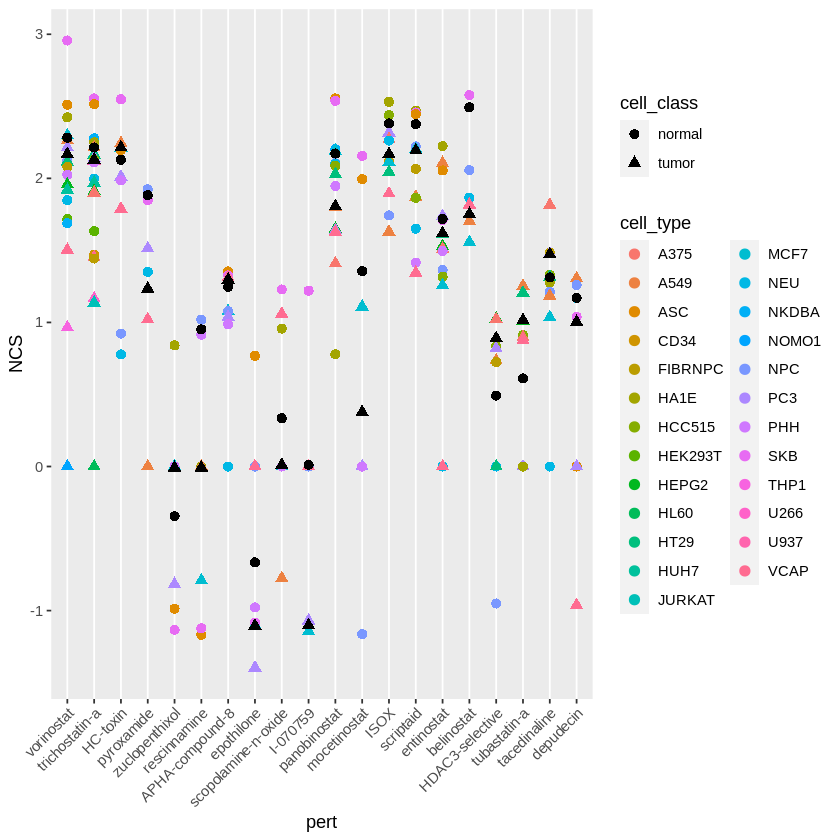

In [17]:
vor_qsig_full <- qSig(query = list(upset=upset, downset=downset), 
                   gess_method="LINCS", refdb="lincs")
vori_res_full <- gess_lincs(qSig=vor_qsig_full, sortby="NCS", tau=TRUE)
vori_tb <- result(vori_res_full)
drugs_top10 <- unique(result(lincs)$pert)[1:10]
drugs_hdac <- c("panobinostat","mocetinostat","ISOX","scriptaid","entinostat",
      "belinostat","HDAC3-selective","tubastatin-a","tacedinaline","depudecin")
drugs = c(drugs_top10, drugs_hdac)
gess_res_vis(vori_tb, drugs = drugs, col = "NCS")

see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation

loading from cache



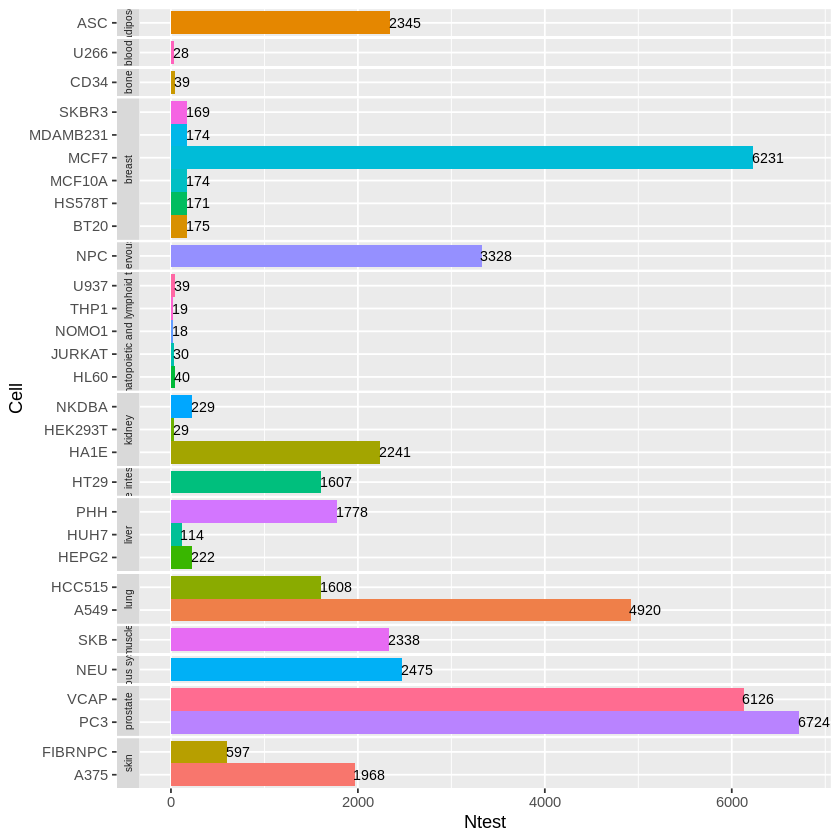

In [18]:
cellNtestPlot(refdb='lincs')

In [19]:
data('cell_info')
cell_info

cell_id,cell_type,primary_site,subtype,donor_sex
<chr>,<chr>,<chr>,<chr>,<chr>
A375,tumor,skin,malignant melanoma,F
A549,tumor,lung,non small cell lung cancer| carcinoma,M
BT20,tumor,breast,carcinoma,F
HA1E,normal,kidney,normal kidney,unknown
HCC515,normal,lung,carcinoma,unknown
HEK293T,normal,kidney,embryonal kidney,unknown
HEPG2,tumor,liver,hepatocellular carcinoma,M
HL60,tumor,haematopoietic and lymphoid tissue,acute myelogenous leukemia (AML)| M3 (promyelocytic),F
HS578T,tumor,breast,carcinoma,F


# Batch processing of GESSs
The above 5 GESS methods support searching reference database parallelly by defining the workers parameter, the default is 1. It means that when submitting one query, the parallelization happens on the GES database level where one splits up a single query process into searching several chunks of the database in parallel. Multiple GES queries can also be processed sequentially or in parallel mode. Parallel evaluations can substantially reduce processing times. The parallelization techniques covered in this vignette, are based on utilities of the BiocParallel and batchtools packages. For demonstration purposes the following example uses a small batch query containing several GESs. First, this batch query is processed sequentially without any parallelization using a simple lapply loop. Next, the same query is processed in parallel mode using multiple CPU cores of a single machine. The third option demonstrates how this query can be processed in parallel mode on multiple machines of a computer cluster with a workload management (queueing) system (e.g. Slurm or Torque).

## 1. Sequential Processsing


In [20]:
library(readr)
batch_queries <- list(q1=list(upset=c("23645", "5290"), downset=c("54957", "2767")),
                      q2=list(upset=c("27101","65083"), downset=c("5813", "84")))
refdb <- system.file("extdata", "sample_db.h5", package="signatureSearch")
gess_list <- lapply(seq_along(batch_queries), function(i){
    qsig_lincs <- qSig(query = batch_queries[[i]], 
                   gess_method="LINCS", refdb=refdb)
    lincs <- gess_lincs(qsig_lincs, sortby="NCS", tau=TRUE)
    if(!dir.exists("batch_res")){
        dir.create("batch_res")
    }
    write_tsv(result(lincs), paste0("batch_res/lincs_res_", i, ".tsv"))
    return(result(lincs))
})

2 / 2 genes in up set share identifiers with reference database

2 / 2 genes in down set share identifiers with reference database

Warning message in .lincsScores(esout = ESout, upset = upset, downset = downset, :
“QueryDB and tauRefDB differ by 99.8% of their entries. Accurate tau computation requires close to 0% divergence. 
”
2 / 2 genes in up set share identifiers with reference database

1 / 2 genes in down set share identifiers with reference database

Warning message in .lincsScores(esout = ESout, upset = upset, downset = downset, :
“QueryDB and tauRefDB differ by 99.8% of their entries. Accurate tau computation requires close to 0% divergence. 
”


## 2. Parallelization with Multiple CPU Cores
The GESSs from the previous example can be accelerated by taking advantage of multiple CPU cores available on a single computer system. The parallel evaluation happens in the below bplapply loop defined by the BiocParallel package. For this approach, all processing instructions are encapsulated in a function named f_bp that will be executed in the bplapply loop. As before, the search results are written to tab-delimited tabular files under a directory called batch_res. The name and path of this directory can be changed as needed. For more background information on this and the following parallelization options, users want to consult the vignette of the BiocParallel package.

In [21]:
# library(BiocParallel)
# f_bp <- function(i){
#     qsig_lincs <- qSig(query = batch_queries[[i]], 
#                    gess_method="LINCS", refdb=refdb)
#     lincs <- gess_lincs(qsig_lincs, sortby="NCS", tau=TRUE)
#     if(!dir.exists("batch_res")){
#         dir.create("batch_res")
#     }
#     write_tsv(result(lincs), paste0("batch_res/lincs_res_", i, ".tsv"))
#     return(result(lincs))
# }
# gess_list <- bplapply(seq_along(batch_queries), f_bp, BPPARAM = MulticoreParam(workers = 2))

## 3. Parallelization with Multiple Computer Systems
In addition to utilizing multiple CPU cores of a single machine, one can further accelerate the processing by taking advantage of multiple computer systems (nodes) available on a computer cluster, where a queueing systems takes care of the load balancing.

In the following example, Njobs sets the number of independent processes to be run on the cluster, and ncpus defines the number of CPU cores to be used by each process. The chosen example will run 2 processes each utilizing 4 CPU cores. If batch_queries contains sufficient GESs and the corresponding computing resources are available on a cluster, then the given example process will utilize in total 8 CPU cores. Note, the given sample code will work on most queueing systems as it is based on utilities from the batchtools package. The latter supports template files (*.tmpl) for defining the run parameters of different schedulers. To run this code, one needs to have both a conf file (see .batchtools.conf.R samples here) and a template file (see *.tmpl samples here) for the queueing system available on a cluster. The following example uses the sample conf and template files for the Slurm scheduler.

For additional details on parallelizing computations on clusters, users want to consult the vignettes of the batchtools and BiocParallel packages.

In [22]:
# library(batchtools)
# batch_queries <- list(q1=list(upset=c("23645", "5290"), downset=c("54957", "2767")),
#                       q2=list(upset=c("27101","65083"), downset=c("5813", "84")))
# refdb <- system.file("extdata", "sample_db.h5", package="signatureSearch")

# f_bt <- function(i, batch_queries, refdb){
#     library(signatureSearch)
#     library(readr)
#     qsig_lincs <- qSig(query = batch_queries[[i]], 
#                    gess_method="LINCS", refdb=refdb)
#     lincs <- gess_lincs(qsig_lincs, sortby="NCS", tau=TRUE)
#     if(!dir.exists("batch_res")){
#         dir.create("batch_res")
#     }
#     write_tsv(result(lincs), paste0("batch_res/lincs_res_", i, ".tsv"))
#     return(result(lincs)) # or return()
# }

In [23]:
# file.copy(system.file("extdata", ".batchtools.conf.R", package="signatureSearch"), ".")
# file.copy(system.file("extdata", "slurm.tmpl", package="signatureSearch"), ".")

In [24]:
# reg <- makeRegistry(file.dir="reg_batch", conf.file=".batchtools.conf.R")
# # reg <- loadRegistry(file.dir="reg_batch", conf.file=".batchtools.conf.R", writeable=TRUE)
# Njobs <- 1:2
# ids <- batchMap(fun=f_bt, Njobs, more.args = list(
#           batch_queries=batch_queries, refdb=refdb))
# submitJobs(ids, reg=reg, resources=list(
#       partition="intel", walltime=120, ntasks=1, ncpus=4, memory=10240))
# getStatus()
# waitForJobs() # Wait until all jobs are completed
# res1 <- loadResult(1)
# unlink(c(".batchtools.conf.R", "slurm.tmpl"))


# Functional Enrichment
GESS results are lists of perturbagens (here drugs) ranked by their signature similarity to a GES-Q of interest. Interpreting these search results with respect to the cellular networks and pathways affected by the top ranking drugs is difficult. To overcome this challenge, the knowledge of the target proteins of the top ranking drugs can be used to perform functional enrichment analysis (FEA) based on community annotation systems, such as Gene Ontologies (GO), pathways (e.g. KEGG, Reactome), drug MOAs or Pfam domains. For this, the ranked drug sets are converted into target gene/protein sets to perform Target Set Enrichment Analysis (TSEA) based on a chosen annotation system. Alternatively, the functional annotation categories of the targets can be assigned to the drugs directly to perform Drug Set Enrichment Analysis (DSEA). Although TSEA and DSEA are related, their enrichment results can be distinct. This is mainly due to duplicated targets present in the test sets of the TSEA methods, whereas the drugs in the test sets of DSEA are usually unique. Additional reasons include differences in the universe sizes used for TSEA and DSEA.

Importantly, the duplications in the test sets of the TSEA are due to the fact that many drugs share the same target proteins. Standard enrichment methods would eliminate these duplications since they assume uniqueness in the test sets. Removing duplications in TSEA would be inappropriate since it would erase one of the most important pieces of information of this approach. To solve this problem, we have developed and implemented in the signatureSearch package a weighting method for duplicated targets, where the weighting is proportional to the frequency of the targets in the test set.

To perform TSEA and DSEA, drug-target annotations are essential. They can be obtained from several sources, including DrugBank, ChEMBL, STITCH, and the Touchstone dataset from the LINCS project (Wishart et al. 2018; Gaulton et al. 2017; Kuhn et al. 2010; Subramanian et al. 2017). Most drug-target annotations provide UniProt identifiers for the target proteins. They can be mapped, if necessary via their encoding genes, to the chosen functional annotation categories, such as GO or KEGG. To minimize bias in TSEA or DSEA, often caused by promiscuous binders, it can be beneficial to remove drugs or targets that bind to large numbers of distinct proteins or drugs, respectively. To conduct TSEA and DSEA efficiently, signatureSearch and its helper package signatureSearchData provide several convenience utilities along with drug-target lookup resources for automating the mapping from drug sets to target sets to functional categories.

Note, most FEA tests involving proteins in their test sets are performed on the gene level in signatureSearch. This way one can avoid additional duplications due to many-to-one relationships among proteins and their encoding genes. For this, the corresponding functions in signatureSearch will usually translate target protein sets into their encoding gene sets using identifier mapping resources from R/Bioconductor, such as the org.Hs.eg.db annotation package. Because of this as well as simplicity, the text in the vignette and help files of this package will refer to the targets of drugs almost interchangeably as proteins or genes, even though the former are the direct targets and the latter only the indirect targets of drugs.


## 1. TSEA
- perform TSEA on drug-based GESS results using as functional annotation systems GO, KEGG and Reactome pathways. The enrichment tests are performed w/ 3 widely used algos that have been modified in `signatureSearch` to take advantage of duplication information present in the test sets used for TSEA.

### Hypergeometric test
$p = \sum_{k = x}^n \frac{{D \choose k} {N-D \choose n-k}}{N \choose n}$
In case of GO term enrichment analysis the individual variables are assigned the following components. N
 is the total number of genes/proteins contained in the entire annotation universe; D
 is the number of genes annotated at a specific GO node; n
 is the total number of genes in the test set; and x
 is the number of genes in the test set annotated at a specific GO node. To maintain the duplication information in the test sets used for TSEA, the values of n
 and x
 in the above equation are adjusted by the frequency of the target proteins in the test set. Effectively, the approach removes the duplications, but maintains their frequency information in form of weighting values.

In [25]:
BiocManager::install('org.Hs.eg.db')

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'org.Hs.eg.db'

Old packages: 'signatureSearch', 'broom', 'cpp11', 'gert', 'glue', 'openssl',
  'sessioninfo', 'tibble', 'tinytex', 'uuid', 'xfun', 'nlme'



In [26]:
# with GO
drugs <- unique(result(lincs)$pert[1:10])
dup_hyperG_res <- tsea_dup_hyperG(drugs = drugs, universe = "Default", 
                                  type = "GO", ont="MF", pvalueCutoff=0.05, 
                                  pAdjustMethod="BH", qvalueCutoff = 0.1, 
                                  minGSSize = 10, maxGSSize = 500)
dup_hyperG_res

No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759


Loading required package: org.Hs.eg.db

Loading required package: AnnotationDbi





#
# Functional Enrichment Analysis 
#
#...@organism 	 Homo sapiens 
#...@ontology 	 MF 
#...@drugs 	 chr [1:10] "vorinostat" "trichostatin-a" "hc-toxin" "pyroxamide" ...
#...@targets 	 chr [1:41] "HDAC1" "HDAC10" "HDAC11" "HDAC2" "HDAC3" "HDAC4" "HDAC5" ...
#...71 enriched terms found
# A tibble: 71 × 10
   ont   ID     Description  GeneRatio BgRatio   pvalue p.adjust   qvalue itemID
   <chr> <chr>  <chr>        <chr>     <chr>      <dbl>    <dbl>    <dbl> <chr> 
 1 MF    GO:00… NAD-depende… 26/41     16/193… 0        0        0        HDAC1…
 2 MF    GO:00… histone dea… 26/41     11/193… 0        0        0        HDAC1…
 3 MF    GO:00… NAD-depende… 26/41     11/193… 0        0        0        HDAC1…
 4 MF    GO:00… NAD-depende… 26/41     17/193… 0        0        0        HDAC1…
 5 MF    GO:00… histone dea… 26/41     44/193… 9.55e-63 1.65e-60 5.49e-61 HDAC1…
 6 MF    GO:00… protein dea… 26/41     45/193… 2.26e-62 3.41e-60 1.14e-60 HDAC1…
 7 MF    GO:00… deacetylase… 26/41     58/193…

In [27]:
result(dup_hyperG_res)

ont,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,itemID,Count
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
MF,GO:0017136,NAD-dependent histone deacetylase activity,26/41,16/19330,0.000000e+00,0.000000e+00,0.000000e+00,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
MF,GO:0031078,histone deacetylase activity (H3-K14 specific),26/41,11/19330,0.000000e+00,0.000000e+00,0.000000e+00,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
MF,GO:0032041,NAD-dependent histone deacetylase activity (H3-K14 specific),26/41,11/19330,0.000000e+00,0.000000e+00,0.000000e+00,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
MF,GO:0034979,NAD-dependent protein deacetylase activity,26/41,17/19330,0.000000e+00,0.000000e+00,0.000000e+00,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
MF,GO:0004407,histone deacetylase activity,26/41,44/19330,9.549739e-63,1.645284e-60,5.485715e-61,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
MF,GO:0033558,protein deacetylase activity,26/41,45/19330,2.260086e-62,3.407080e-60,1.135991e-60,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
MF,GO:0019213,deacetylase activity,26/41,58/19330,2.033182e-58,2.724464e-56,9.083926e-57,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
MF,GO:0016811,"hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides",26/41,89/19330,1.851535e-52,1.860793e-50,6.204266e-51,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
MF,GO:0016810,"hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds",26/41,147/19330,4.542664e-46,3.424033e-44,1.141643e-44,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26


In [28]:
# KEGG
dup_hyperG_k_res <- tsea_dup_hyperG(drugs = drugs, universe = "Default", 
                                    type = "KEGG", pvalueCutoff=0.5, 
                                    pAdjustMethod="BH", qvalueCutoff = 0.5, 
                                    minGSSize = 10, maxGSSize = 500)
result(dup_hyperG_k_res)

No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759


Reading KEGG annotation online:


Reading KEGG annotation online:




ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,itemID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa05034,Alcoholism,27/41,187/8105,2.484687e-35,1.093262e-33,4.707828e-34,3065/83933/79885/3066/8841/9759/10014/10013/51564/55869/9734/3065/83933/3066/8841/9759/10014/10013/51564/55869/9734/3065/3065/8841/10013/1812/55869,27
hsa04613,Neutrophil extracellular trap formation,26/41,190/8105,3.408313e-33,7.498290e-32,3.228929e-32,3065/83933/79885/3066/8841/9759/10014/10013/51564/55869/9734/3065/83933/3066/8841/9759/10014/10013/51564/55869/9734/3065/3065/8841/10013/55869,26
hsa05203,Viral carcinogenesis,26/41,204/8105,2.399346e-32,3.519041e-31,1.515377e-31,3065/83933/79885/3066/8841/9759/10014/10013/51564/55869/9734/3065/83933/3066/8841/9759/10014/10013/51564/55869/9734/3065/3065/8841/10013/55869,26
hsa04540,Gap junction,12/41,88/8105,7.571574e-15,8.328732e-14,3.586535e-14,1812/7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,12
hsa05016,Huntington disease,17/41,306/8105,2.766830e-14,2.434810e-13,1.048483e-13,3065/3066/3065/3066/3065/3065/7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,17
hsa04145,Phagosome,11/41,152/8105,1.367536e-10,1.002860e-09,4.318534e-10,7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,11
hsa05014,Amyotrophic lateral sclerosis,14/41,364/8105,1.236296e-09,7.771005e-09,3.346366e-09,10013/10013/10013/7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,14
hsa05130,Pathogenic Escherichia coli infection,11/41,197/8105,2.211707e-09,1.216439e-08,5.238254e-09,7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,11
hsa05012,Parkinson disease,12/41,266/8105,4.124709e-09,2.016524e-08,8.683598e-09,1812/7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,12


In [29]:
# Reactome
dup_rct_res <- tsea_dup_hyperG(drugs=drugs, type="Reactome",
                               pvalueCutoff=0.5, qvalueCutoff=0.5, readable=TRUE)
result(dup_rct_res)

No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759




ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,itemID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-193670,p75NTR negatively regulates cell cycle via SC1,9/41,6/10867,0.000000e+00,0.000000e+00,0.000000e+00,HDAC1/HDAC2/HDAC3/HDAC1/HDAC2/HDAC3/HDAC1/HDAC1/HDAC3,9
R-HSA-350054,Notch-HLH transcription pathway,26/41,28/10867,1.143959e-65,1.063881e-63,1.083750e-64,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
R-HSA-2122947,NOTCH1 Intracellular Domain Regulates Transcription,26/41,48/10867,8.069550e-55,5.003121e-53,5.096558e-54,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
R-HSA-2644602,Signaling by NOTCH1 PEST Domain Mutants in Cancer,26/41,58/10867,6.440257e-52,1.497360e-50,1.525324e-51,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
R-HSA-2644603,Signaling by NOTCH1 in Cancer,26/41,58/10867,6.440257e-52,1.497360e-50,1.525324e-51,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
R-HSA-2644606,Constitutive Signaling by NOTCH1 PEST Domain Mutants,26/41,58/10867,6.440257e-52,1.497360e-50,1.525324e-51,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
R-HSA-2894858,Signaling by NOTCH1 HD+PEST Domain Mutants in Cancer,26/41,58/10867,6.440257e-52,1.497360e-50,1.525324e-51,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
R-HSA-2894862,Constitutive Signaling by NOTCH1 HD+PEST Domain Mutants,26/41,58/10867,6.440257e-52,1.497360e-50,1.525324e-51,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
R-HSA-1980143,Signaling by NOTCH1,26/41,74/10867,1.880392e-48,3.886144e-47,3.958721e-48,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26


## 2. mGSEA method


In [30]:
# GO
mgsea_res <- tsea_mGSEA(drugs = drugs, type='GO', ont='MF', exponent=1,
                        nPerm = 1000, pvalueCutoff = 1, minGSSize=5)
result(mgsea_res)                      

No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759




ont,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,leadingEdge,ledge_rank
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
MF,GO:0031078,histone deacetylase activity (H3-K14 specific),11,0.99984572,3.8672302,0.001,0.6275000,0.6275000,HDAC1/HDAC3/HDAC6/HDAC8/HDAC10/HDAC2/HDAC4/HDAC5/HDAC7/HDAC9/HDAC11,1/2/3/4/5/6/7/8/9/10/14
MF,GO:0032041,NAD-dependent histone deacetylase activity (H3-K14 specific),11,0.99984572,3.8672302,0.001,0.6275000,0.6275000,HDAC1/HDAC3/HDAC6/HDAC8/HDAC10/HDAC2/HDAC4/HDAC5/HDAC7/HDAC9/HDAC11,1/2/3/4/5/6/7/8/9/10/14
MF,GO:0017136,NAD-dependent histone deacetylase activity,16,0.83855536,3.7836720,0.011,0.7172965,0.7172965,HDAC1/HDAC3/HDAC6/HDAC8/HDAC10/HDAC2/HDAC4/HDAC5/HDAC7/HDAC9/HDAC11,1/2/3/4/5/6/7/8/9/10/14
MF,GO:0034979,NAD-dependent protein deacetylase activity,17,0.81234567,3.7626916,0.013,0.7172965,0.7172965,HDAC1/HDAC3/HDAC6/HDAC8/HDAC10/HDAC2/HDAC4/HDAC5/HDAC7/HDAC9/HDAC11,1/2/3/4/5/6/7/8/9/10/14
MF,GO:0004407,histone deacetylase activity,44,0.44052342,2.7995162,0.033,0.7172965,0.7172965,HDAC1/HDAC3/HDAC6/HDAC8/HDAC10/HDAC2/HDAC4/HDAC5/HDAC7/HDAC9/HDAC11,1/2/3/4/5/6/7/8/9/10/14
MF,GO:0033558,protein deacetylase activity,45,0.43317878,2.7163464,0.037,0.7172965,0.7172965,HDAC1/HDAC3/HDAC6/HDAC8/HDAC10/HDAC2/HDAC4/HDAC5/HDAC7/HDAC9/HDAC11,1/2/3/4/5/6/7/8/9/10/14
MF,GO:0019213,deacetylase activity,58,0.35600973,2.2812622,0.049,0.7172965,0.7172965,HDAC1/HDAC3/HDAC6/HDAC8/HDAC10/HDAC2/HDAC4/HDAC5/HDAC7/HDAC9/HDAC11,1/2/3/4/5/6/7/8/9/10/14
MF,GO:0051059,NF-kappaB binding,28,0.26455147,1.4505699,0.043,0.7172965,0.7172965,HDAC1/HDAC3/HDAC2,1/2/6
MF,GO:0016811,"hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides",89,0.24984510,1.4659929,0.087,0.7172965,0.7172965,HDAC1/HDAC3/HDAC6/HDAC8/HDAC10/HDAC2/HDAC4/HDAC5/HDAC7/HDAC9/HDAC11,1/2/3/4/5/6/7/8/9/10/14


In [31]:
mgsea_k_res <- tsea_mGSEA(drugs=drugs, type="KEGG", exponent=1, 
                          nPerm=1000, pvalueCutoff=1, minGSSize=2)
result(mgsea_k_res)

No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759




ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,leadingEdge,ledge_rank
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
hsa04540,Gap junction,88,0.134617347,0.414849102,0.280,0.8626047,0.8626047,10376/10381/10382/10383/1812/203068/51807/7277/7278/7846/81027/84790,11/12/13/14/17/18/20/21/22/23/25/26
hsa05034,Alcoholism,187,0.132147832,0.268122939,0.460,0.8626047,0.8626047,3065/10013/55869/8841/10014/3066/51564/83933/9734/9759/1812/79885,1/2/3/4/5/6/7/8/9/10/17/24
hsa04613,Neutrophil extracellular trap formation,190,0.125186817,0.253143631,0.463,0.8626047,0.8626047,3065/10013/55869/8841/10014/3066/51564/83933/9734/9759/79885,1/2/3/4/5/6/7/8/9/10/24
hsa05203,Viral carcinogenesis,204,0.117076100,0.226183329,0.490,0.8626047,0.8626047,3065/10013/55869/8841/10014/3066/51564/83933/9734/9759/79885,1/2/3/4/5/6/7/8/9/10/24
hsa04330,Notch signaling pathway,59,0.094740954,0.353012684,0.426,0.8626047,0.8626047,3065/3066,1/6
hsa05031,Amphetamine addiction,69,0.094148251,0.327762767,0.409,0.8626047,0.8626047,3065/3066/1812,1/6/17
hsa04213,Longevity regulating pathway - multiple species,62,0.090411764,0.329760785,0.452,0.8626047,0.8626047,3065/3066,1/6
hsa05220,Chronic myeloid leukemia,76,0.074501806,0.245790212,0.512,0.8626047,0.8626047,3065/3066,1/6
hsa04919,Thyroid hormone signaling pathway,121,0.070490390,0.187560321,0.518,0.8626047,0.8626047,3065/8841/3066,1/4/6


In [32]:
drugs

[1] "vorinostat"          "trichostatin-a"      "HC-toxin"           
 [4] "pyroxamide"          "zuclopenthixol"      "rescinnamine"       
 [7] "APHA-compound-8"     "epothilone"          "scopolamine-n-oxide"
[10] "I-070759"

In [33]:
# KEGG
mgsea_rct_res <- tsea_mGSEA(drugs=drugs, type="Reactome", pvalueCutoff=1,
                            readable=TRUE)
result(mgsea_rct_res)

No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759




ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,leadingEdge,ledge_rank
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
R-HSA-193670,p75NTR negatively regulates cell cycle via SC1,6,0.7497238,2.216827,0.018,0.736061,0.736061,HDAC1/HDAC3/HDAC2,1/4/6
R-HSA-350054,Notch-HLH transcription pathway,28,0.6034518,2.724265,0.073,0.736061,0.736061,HDAC1/HDAC6/HDAC8/HDAC3/HDAC5/HDAC2/HDAC7/HDAC10/HDAC9/HDAC4/HDAC11,1/2/3/4/5/6/7/8/9/10/24
R-HSA-9701898,STAT3 nuclear events downstream of ALK signaling,10,0.5622237,1.999238,0.030,0.736061,0.736061,HDAC1/HDAC3/HDAC2,1/4/6
R-HSA-190840,Microtubule-dependent trafficking of connexons from Golgi to the plasma membrane,18,0.5540808,2.365466,0.045,0.736061,0.736061,TUBA1B/TUBB3/TUBB4A/TUBB4B/TUBA8/TUBA4A/TUBA3C/TUBA1A/TUBB1/TUBA1C,11/12/13/14/20/21/22/23/25/26
R-HSA-190872,Transport of connexons to the plasma membrane,19,0.5248409,2.248782,0.049,0.736061,0.736061,TUBA1B/TUBB3/TUBB4A/TUBB4B/TUBA8/TUBA4A/TUBA3C/TUBA1A/TUBB1/TUBA1C,11/12/13/14/20/21/22/23/25/26
R-HSA-389977,Post-chaperonin tubulin folding pathway,22,0.4530701,2.032002,0.054,0.736061,0.736061,TUBA1B/TUBB3/TUBB4A/TUBB4B/TUBA8/TUBA4A/TUBA3C/TUBA1A/TUBB1/TUBA1C,11/12/13/14/20/21/22/23/25/26
R-HSA-2122947,NOTCH1 Intracellular Domain Regulates Transcription,48,0.4114968,1.820911,0.117,0.736061,0.736061,HDAC1/HDAC6/HDAC8/HDAC3/HDAC5/HDAC2/HDAC7/HDAC10/HDAC9/HDAC4/HDAC11,1/2/3/4/5/6/7/8/9/10/24
R-HSA-389960,Formation of tubulin folding intermediates by CCT/TriC,25,0.3985243,1.800652,0.063,0.736061,0.736061,TUBA1B/TUBB3/TUBB4A/TUBB4B/TUBA8/TUBA4A/TUBA3C/TUBA1A/TUBB1/TUBA1C,11/12/13/14/20/21/22/23/25/26
R-HSA-9005891,Loss of function of MECP2 in Rett syndrome,14,0.3682368,1.452392,0.048,0.736061,0.736061,HDAC1/HDAC3,1/4


### 3. MeanAbs

In [34]:
mabs_res <- tsea_mabs(drugs=drugs, type="GO", ont="MF", nPerm=1000, 
                      pvalueCutoff=0.05, minGSSize=5)
result(mabs_res)

mabs_k_res <- tsea_mabs(drugs=drugs, type="KEGG", nPerm=1000, 
                        pvalueCutoff=0.2, minGSSize=5)
result(mabs_k_res)

mabs_rct_res <- tsea_mabs(drugs=drugs, type="Reactome", pvalueCutoff=1,
                          readable=TRUE)
result(mabs_rct_res)

No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759




ont,ID,Description,setSize,mabs,Nmabs,pvalue,p.adjust,qvalues,itemID
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
MF,GO:0031078,histone deacetylase activity (H3-K14 specific),11,0.057649667,29.771860,0.000,0.000000000,0.000000000,HDAC1/HDAC2/HDAC3/HDAC9/HDAC4/HDAC6/HDAC5/HDAC7/HDAC8/HDAC11/HDAC10
MF,GO:0032041,NAD-dependent histone deacetylase activity (H3-K14 specific),11,0.057649667,29.771860,0.000,0.000000000,0.000000000,HDAC1/HDAC2/HDAC3/HDAC9/HDAC4/HDAC6/HDAC5/HDAC7/HDAC8/HDAC11/HDAC10
MF,GO:0017136,NAD-dependent histone deacetylase activity,16,0.039634146,28.869879,0.000,0.000000000,0.000000000,HDAC1/HDAC2/HDAC3/HDAC9/HDAC4/HDAC6/HDAC5/HDAC7/HDAC8/HDAC11/HDAC10
MF,GO:0034979,NAD-dependent protein deacetylase activity,17,0.037302726,28.805178,0.000,0.000000000,0.000000000,HDAC1/HDAC2/HDAC3/HDAC9/HDAC4/HDAC6/HDAC5/HDAC7/HDAC8/HDAC11/HDAC10
MF,GO:0004407,histone deacetylase activity,44,0.014412417,26.933146,0.000,0.000000000,0.000000000,HDAC1/HDAC2/HDAC3/HDAC9/HDAC4/HDAC6/HDAC5/HDAC7/HDAC8/HDAC11/HDAC10
MF,GO:0033558,protein deacetylase activity,45,0.014092141,26.884444,0.000,0.000000000,0.000000000,HDAC1/HDAC2/HDAC3/HDAC9/HDAC4/HDAC6/HDAC5/HDAC7/HDAC8/HDAC11/HDAC10
MF,GO:0019213,deacetylase activity,58,0.010933558,26.178752,0.000,0.000000000,0.000000000,HDAC1/HDAC2/HDAC3/HDAC9/HDAC4/HDAC6/HDAC5/HDAC7/HDAC8/HDAC11/HDAC10
MF,GO:0051059,NF-kappaB binding,28,0.007839721,20.595129,0.000,0.000000000,0.000000000,HDAC1/HDAC2/HDAC3
MF,GO:0016811,"hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides",89,0.007125240,24.705862,0.000,0.000000000,0.000000000,HDAC1/HDAC2/HDAC3/HDAC9/HDAC4/HDAC6/HDAC5/HDAC7/HDAC8/HDAC11/HDAC10


No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759




ID,Description,setSize,mabs,Nmabs,pvalue,p.adjust,qvalues,itemID
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
hsa05034,Alcoholism,187,0.0035215860,16.7826082,0.000,0.000000000,0.0000000000,10013/10014/1812/3065/3066/51564/55869/79885/83933/8841/9734/9759
hsa04613,Neutrophil extracellular trap formation,190,0.0033376123,15.7749929,0.000,0.000000000,0.0000000000,10013/10014/3065/3066/51564/55869/79885/83933/8841/9734/9759
hsa04540,Gap junction,88,0.0033259424,11.5414923,0.000,0.000000000,0.0000000000,10376/10381/10382/10383/1812/203068/51807/7277/7278/7846/81027/84790
hsa05203,Viral carcinogenesis,204,0.0031085605,15.7662546,0.000,0.000000000,0.0000000000,10013/10014/3065/3066/51564/55869/79885/83933/8841/9734/9759
hsa04330,Notch signaling pathway,59,0.0024803638,7.0329402,0.001,0.002200000,0.0008947368,3065/3066
hsa05031,Amphetamine addiction,69,0.0024743726,7.7912403,0.000,0.000000000,0.0000000000,1812/3065/3066
hsa04213,Longevity regulating pathway - multiple species,62,0.0023603462,7.8075934,0.000,0.000000000,0.0000000000,3065/3066
hsa05220,Chronic myeloid leukemia,76,0.0019255456,6.3827669,0.000,0.000000000,0.0000000000,3065/3066
hsa04919,Thyroid hormone signaling pathway,121,0.0018141504,8.2960906,0.000,0.000000000,0.0000000000,3065/3066/8841


No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759




ID,Description,setSize,mabs,Nmabs,pvalue,p.adjust,qvalues,itemID
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
R-HSA-193670,p75NTR negatively regulates cell cycle via SC1,6,0.036585366,26.52905,0.000,0.000000000,0.0000000000,HDAC1/HDAC2/HDAC3
R-HSA-350054,Notch-HLH transcription pathway,28,0.022648084,28.08201,0.000,0.000000000,0.0000000000,HDAC6/HDAC5/HDAC1/HDAC2/HDAC7/HDAC8/HDAC11/HDAC10/HDAC3/HDAC9/HDAC4
R-HSA-9701898,STAT3 nuclear events downstream of ALK signaling,10,0.021951220,24.35668,0.000,0.000000000,0.0000000000,HDAC1/HDAC2/HDAC3
R-HSA-190840,Microtubule-dependent trafficking of connexons from Golgi to the plasma membrane,18,0.013550136,19.91941,0.000,0.000000000,0.0000000000,TUBA1B/TUBB3/TUBB4A/TUBB4B/TUBA8/TUBA4A/TUBA3C/TUBA1A/TUBB1/TUBA1C
R-HSA-2122947,NOTCH1 Intracellular Domain Regulates Transcription,48,0.013211382,25.57905,0.000,0.000000000,0.0000000000,HDAC6/HDAC5/HDAC1/HDAC2/HDAC7/HDAC8/HDAC11/HDAC10/HDAC3/HDAC9/HDAC4
R-HSA-190872,Transport of connexons to the plasma membrane,19,0.012836970,19.57476,0.000,0.000000000,0.0000000000,TUBA1B/TUBB3/TUBB4A/TUBB4B/TUBA8/TUBA4A/TUBA3C/TUBA1A/TUBB1/TUBA1C
R-HSA-9022702,MECP2 regulates transcription of neuronal ligands,8,0.012195122,18.93978,0.000,0.000000000,0.0000000000,HDAC1
R-HSA-9005891,Loss of function of MECP2 in Rett syndrome,14,0.012195122,17.72823,0.000,0.000000000,0.0000000000,HDAC1/HDAC3
R-HSA-9005895,Pervasive developmental disorders,14,0.012195122,17.72823,0.000,0.000000000,0.0000000000,HDAC1/HDAC3


## DSEA

### 1. Hypergeometric

In [35]:
drugs <- unique(result(lincs)$pert[1:10])
hyperG_res <- dsea_hyperG(drugs=drugs, type='GO', ont='MF')
result(hyperG_res)

ont,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,itemID,Count
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
MF,GO:0035851,Krueppel-associated box domain binding,4/8,27/22568,1.133215e-10,5.892719e-08,1.729644e-08,vorinostat/trichostatin-a/hc-toxin/pyroxamide,4
MF,GO:0031078,histone deacetylase activity (H3-K14 specific),5/8,199/22568,2.778580e-09,3.042474e-07,8.930338e-08,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,5
MF,GO:0032041,NAD-dependent histone deacetylase activity (H3-K14 specific),5/8,199/22568,2.778580e-09,3.042474e-07,8.930338e-08,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,5
MF,GO:0017136,NAD-dependent histone deacetylase activity,5/8,261/22568,1.083945e-08,3.382311e-07,9.927836e-08,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,5
MF,GO:0034979,NAD-dependent protein deacetylase activity,5/8,266/22568,1.192028e-08,3.382311e-07,9.927836e-08,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,5
MF,GO:0031492,nucleosomal DNA binding,4/8,88/22568,1.492725e-08,3.881085e-07,1.139185e-07,vorinostat/trichostatin-a/hc-toxin/pyroxamide,4
MF,GO:0001046,core promoter sequence-specific DNA binding,4/8,94/22568,1.950428e-08,4.610103e-07,1.353168e-07,vorinostat/trichostatin-a/hc-toxin/pyroxamide,4
MF,GO:0004407,histone deacetylase activity,5/8,318/22568,2.911950e-08,6.108402e-07,1.792952e-07,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,5
MF,GO:0033558,protein deacetylase activity,5/8,323/22568,3.147974e-08,6.108772e-07,1.793061e-07,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,5


In [36]:
# KEGG
hyperG_k_res <- dsea_hyperG(drugs=drugs, type='KEGG',
                            pvalueCutoff = 1, qvalueCutoff = 1,
                            minGSSize = 10, maxGSSize = 2000)
result(hyperG_k_res)                            

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,itemID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04330,Notch signaling pathway,4/8,146/20464,1.702210e-07,6.638621e-06,4.300321e-06,vorinostat/trichostatin-a/hc-toxin/pyroxamide,4
hsa05034,Alcoholism,6/8,1131/20464,7.155232e-07,1.395270e-05,9.038187e-06,vorinostat/trichostatin-a/hc-toxin/pyroxamide/zuclopenthixol/apha-compound-8,6
hsa05031,Amphetamine addiction,5/8,916/20464,8.891270e-06,1.155865e-04,7.487385e-05,vorinostat/trichostatin-a/hc-toxin/pyroxamide/zuclopenthixol,5
hsa05203,Viral carcinogenesis,5/8,1175/20464,2.995078e-05,2.244118e-04,1.453680e-04,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,5
hsa05016,Huntington disease,5/8,1185/20464,3.120945e-05,2.244118e-04,1.453680e-04,vorinostat/trichostatin-a/hc-toxin/pyroxamide/epothilone,5
hsa04613,Neutrophil extracellular trap formation,5/8,1237/20464,3.844183e-05,2.244118e-04,1.453680e-04,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,5
hsa04213,Longevity regulating pathway - multiple species,4/8,578/20464,4.027905e-05,2.244118e-04,1.453680e-04,vorinostat/trichostatin-a/hc-toxin/pyroxamide,4
hsa04110,Cell cycle,4/8,730/20464,1.002403e-04,4.886717e-04,3.165484e-04,vorinostat/trichostatin-a/hc-toxin/pyroxamide,4
hsa05220,Chronic myeloid leukemia,4/8,822/20464,1.589356e-04,6.887208e-04,4.461349e-04,vorinostat/trichostatin-a/hc-toxin/pyroxamide,4


### 2. GSEA method


In [37]:
# GO
dl <- abs(result(lincs)$NCS); names(dl) <- result(lincs)$pert
dl <- dl[dl > 0]
dl <- dl[!duplicated(names(dl))]
gsea_res <- dsea_GSEA(drugList = dl, type='GO', ont='MF', exponent = 1, nPerm=1000,
                      pvalueCutoff = 0.2, minGSSize = 5)
result(gsea_res)                      

ont,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,leadingEdge,ledge_rank
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
MF,GO:0004407,histone deacetylase activity,5,0.9512195,2.831582,0.000999001,0.01562805,0.01031032,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,1/2/3/4/7
MF,GO:0016811,"hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides",5,0.9512195,2.831582,0.000999001,0.01562805,0.01031032,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,1/2/3/4/7
MF,GO:0017136,NAD-dependent histone deacetylase activity,5,0.9512195,2.831582,0.000999001,0.01562805,0.01031032,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,1/2/3/4/7
MF,GO:0019213,deacetylase activity,5,0.9512195,2.831582,0.000999001,0.01562805,0.01031032,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,1/2/3/4/7
MF,GO:0031078,histone deacetylase activity (H3-K14 specific),5,0.9512195,2.831582,0.000999001,0.01562805,0.01031032,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,1/2/3/4/7
MF,GO:0032041,NAD-dependent histone deacetylase activity (H3-K14 specific),5,0.9512195,2.831582,0.000999001,0.01562805,0.01031032,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,1/2/3/4/7
MF,GO:0033558,protein deacetylase activity,5,0.9512195,2.831582,0.000999001,0.01562805,0.01031032,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,1/2/3/4/7
MF,GO:0034979,NAD-dependent protein deacetylase activity,5,0.9512195,2.831582,0.000999001,0.01562805,0.01031032,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,1/2/3/4/7
MF,GO:0003714,transcription corepressor activity,5,0.9306673,2.770403,0.000999001,0.01562805,0.01031032,vorinostat/trichostatin-a/hc-toxin/pyroxamide,1/2/3/4


In [38]:
# KEGG
gsea_k_res <- dsea_GSEA(drugList=dl, type="KEGG", exponent=1, nPerm=1000, 
                        pvalueCutoff=1, minGSSize=5)
result(gsea_k_res)

ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,leadingEdge,ledge_rank
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
hsa05031,Amphetamine addiction,8,0.7846215,2.6130321,0.000999001,0.01148851,0.00946422,vorinostat/trichostatin-a/hc-toxin/pyroxamide/zuclopenthixol,1/2/3/4/5
hsa04613,Neutrophil extracellular trap formation,7,0.8068409,2.5893643,0.000999001,0.01148851,0.00946422,vorinostat/trichostatin-a/hc-toxin/pyroxamide/apha-compound-8,1/2/3/4/7
hsa04110,Cell cycle,6,0.8384286,2.5605182,0.000999001,0.01148851,0.00946422,vorinostat/trichostatin-a/hc-toxin/pyroxamide,1/2/3/4
hsa05169,Epstein-Barr virus infection,6,0.8384286,2.5605182,0.000999001,0.01148851,0.00946422,vorinostat/trichostatin-a/hc-toxin/pyroxamide,1/2/3/4
hsa05034,Alcoholism,10,0.7307706,2.5252132,0.001998002,0.01969459,0.01622438,vorinostat/trichostatin-a/hc-toxin/pyroxamide/zuclopenthixol/apha-compound-8,1/2/3/4/5/7
hsa05202,Transcriptional misregulation in cancer,7,0.7715778,2.4761959,0.000999001,0.01148851,0.00946422,vorinostat/trichostatin-a/hc-toxin/pyroxamide,1/2/3/4
hsa04213,Longevity regulating pathway - multiple species,7,0.7619107,2.4451716,0.000999001,0.01148851,0.00946422,vorinostat/trichostatin-a/hc-toxin/pyroxamide,1/2/3/4
hsa05016,Huntington disease,8,0.7179226,2.3909043,0.002997003,0.02297702,0.01892844,vorinostat/trichostatin-a/hc-toxin/pyroxamide/epothilone,1/2/3/4/8
hsa05220,Chronic myeloid leukemia,8,0.7167674,2.3870571,0.002997003,0.02297702,0.01892844,vorinostat/trichostatin-a/hc-toxin/pyroxamide,1/2/3/4


## Comparing FEA Results
The comp_fea_res function re-ranks the functional categories across the different FEA methods by using the mean rank of each functional category across the 5 FEA methods. Here the functional categories are re-ranked by their mean rank values in increasing order. Since the functional categories are not always present in all enrichment results, the mean rank of a functional category is corrected by an adjustment factor that is the number of enrichment result methods used divided by the number of occurrences of a functional category. For instance, if a functional category is only present in the result of one method, its mean rank will be increased accordingly. The following plots use the pvalue column in the result tables for this ranking approach. Alternative columns can be chosen under the rank_stat argument. After re-ranking only the top ranking functional categories are shown, here 20. Their number can be changed under the Nshow argument.

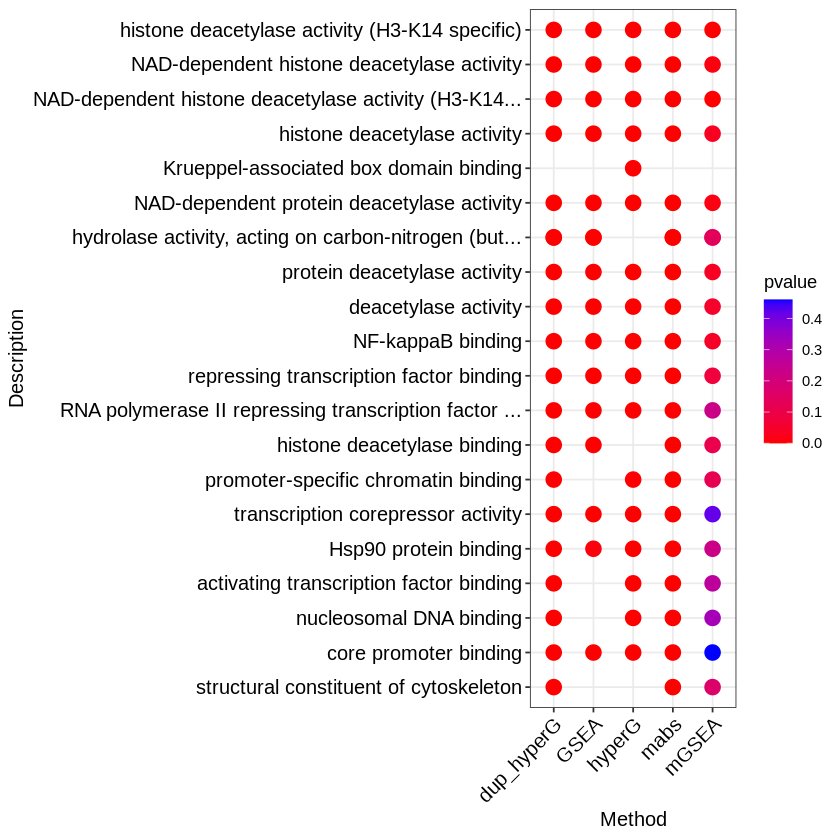

In [39]:
table_list = list("dup_hyperG" = result(dup_hyperG_res), 
                  "mGSEA" = result(mgsea_res), 
                  "mabs" = result(mabs_res), 
                  "hyperG" = result(hyperG_res), 
                  "GSEA" = result(gsea_res))
comp_fea_res(table_list, rank_stat="pvalue", Nshow=20)

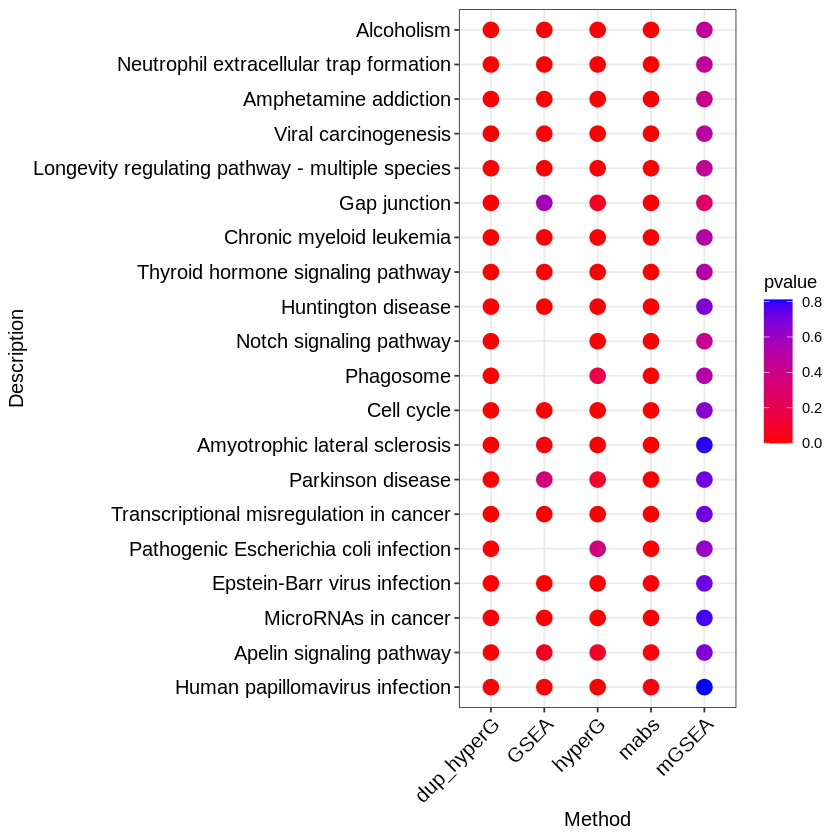

In [40]:
table_list = list("dup_hyperG" = result(dup_hyperG_k_res), 
                  "mGSEA" = result(mgsea_k_res), 
                  "mabs" = result(mabs_k_res), 
                  "hyperG" = result(hyperG_k_res), 
                  "GSEA" = result(gsea_k_res))
comp_fea_res(table_list, rank_stat="pvalue", Nshow=20)

# Drug-Target Network Visualization

In [ ]:
dtnetplot(drugs = drugs(dup_hyperG_res), set = 'GO:0032041', ont = 'MF',
                    desc="NAD-dependent histone deacetylase activity (H3-K14 specific)")

In [ ]:
dtnetplot(drugs = drugs(dup_hyperG_res), set = "GO:0051059", ont = "MF", 
          desc="NF-kappaB binding")

In [ ]:
dtnetplot(drugs = drugs(dup_hyperG_k_res), set = "hsa05034", 
          desc="Alcoholism")

In [ ]:
dtnetplot(drugs = drugs, set = "hsa04213", 
          desc="Longevity regulating pathway - multiple species")

# Run Workflow

In [45]:
drug <- "vorinostat"; cell <- "SKB"
refdb <- system.file("extdata", "sample_db.h5", package="signatureSearch")
env_dir <- tempdir()
wf_list <- runWF(drug, cell, refdb, gess_method="LINCS", 
    fea_method="dup_hyperG", N_gess_drugs=10, env_dir=env_dir, tau=FALSE)

150 / 150 genes in up set share identifiers with reference database

150 / 150 genes in down set share identifiers with reference database

No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759


No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759


No targets found in all databases for 2 drugs: 
scopolamine-n-oxide / i-070759




In [46]:
names(wf_list)

[1] "gess_tb" "mf_tb"   "bp_tb"   "kegg_tb"

In [47]:
wf_list$gess_tb

pert,PCID,cell,type,trend,WTCS,WTCS_Pval,WTCS_FDR,NCS,NCSct,N_upset,N_downset,t_gn_sym
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
vorinostat,5311,SKB,trt_cp,up,1.0000000,0.000000e+00,0.0000000000,2.5663193,2.5663193,150,150,HDAC1; HDAC10; HDAC11; HDAC2; HDAC3; ...
trichostatin-a,444732,SKB,trt_cp,up,0.8632721,5.962030e-06,0.0001804657,2.2154320,2.2154320,150,150,HDAC1; HDAC10; HDAC2; HDAC3; HDAC4; ...
HC-toxin,3571,SKB,trt_cp,up,0.8566409,6.223141e-06,0.0001804657,2.1984140,2.1984140,150,150,HDAC1
pyroxamide,4996,SKB,trt_cp,up,0.6253459,1.631943e-05,0.0001804657,1.6048373,1.6048373,150,150,HDAC1; HDAC3; HDAC6
zuclopenthixol,5311507,SKB,trt_cp,down,-0.3214791,8.285917e-05,0.0003186891,-1.1881347,-1.1881347,150,150,ADRA1A; DRD1; HRH1
rescinnamine,5280954,SKB,trt_cp,down,-0.3188884,9.604526e-05,0.0003557232,-1.1785601,-1.1785601,150,150,ACE
APHA-compound-8,10379137,SKB,trt_cp,up,0.4449388,2.415275e-05,0.0001804657,1.1418551,1.1418551,150,150,HDAC8
epothilone,448013,SKB,trt_cp,down,-0.3075832,2.402220e-04,0.0008007398,-1.1367780,-1.1367780,150,150,TUBA1A; TUBA1B; TUBA1C; TUBA3C; TUBA4A; ...
scopolamine-n-oxide,3000667,SKB,trt_cp,up,0.4156802,2.541479e-05,0.0001804657,1.0667682,1.0667682,150,150,NA


In [48]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ tidyr   1.1.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()      masks matrixStats::count()
✖ dplyr::desc()       masks IRanges::desc()
✖ tidyr::expand()     masks Matrix::expand(), S4Vectors::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first()
✖ dplyr::ident()      masks dbplyr::ident()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks Matrix::pack()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()     masks GenomicRanges::reduce(), IRan

In [49]:
drop_na(wf_list$gess_tb)

pert,PCID,cell,type,trend,WTCS,WTCS_Pval,WTCS_FDR,NCS,NCSct,N_upset,N_downset,t_gn_sym
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
vorinostat,5311,SKB,trt_cp,up,1.0000000,0.000000e+00,0.0000000000,2.5663193,2.5663193,150,150,HDAC1; HDAC10; HDAC11; HDAC2; HDAC3; ...
trichostatin-a,444732,SKB,trt_cp,up,0.8632721,5.962030e-06,0.0001804657,2.2154320,2.2154320,150,150,HDAC1; HDAC10; HDAC2; HDAC3; HDAC4; ...
HC-toxin,3571,SKB,trt_cp,up,0.8566409,6.223141e-06,0.0001804657,2.1984140,2.1984140,150,150,HDAC1
pyroxamide,4996,SKB,trt_cp,up,0.6253459,1.631943e-05,0.0001804657,1.6048373,1.6048373,150,150,HDAC1; HDAC3; HDAC6
zuclopenthixol,5311507,SKB,trt_cp,down,-0.3214791,8.285917e-05,0.0003186891,-1.1881347,-1.1881347,150,150,ADRA1A; DRD1; HRH1
rescinnamine,5280954,SKB,trt_cp,down,-0.3188884,9.604526e-05,0.0003557232,-1.1785601,-1.1785601,150,150,ACE
APHA-compound-8,10379137,SKB,trt_cp,up,0.4449388,2.415275e-05,0.0001804657,1.1418551,1.1418551,150,150,HDAC8
epothilone,448013,SKB,trt_cp,down,-0.3075832,2.402220e-04,0.0008007398,-1.1367780,-1.1367780,150,150,TUBA1A; TUBA1B; TUBA1C; TUBA3C; TUBA4A; ...
warfarin,54678486,SKB,trt_cp,down,-0.2817883,2.448393e-03,0.0069954076,-1.0414442,-1.0414442,150,150,ARSE; CYP2C8; CYP2C9; CYP4F2; F3; ...


In [50]:
drop_na(wf_list$bp_tb)

ont,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,itemID,Count
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
BP,GO:0060789,hair follicle placode formation,6/41,5/19330,0.000000e+00,0.000000e+00,0.000000e+00,HDAC1/HDAC2/HDAC1/HDAC2/HDAC1/HDAC1,6
BP,GO:0061197,fungiform papilla morphogenesis,6/41,5/19330,0.000000e+00,0.000000e+00,0.000000e+00,HDAC1/HDAC2/HDAC1/HDAC2/HDAC1/HDAC1,6
BP,GO:0070932,histone H3 deacetylation,26/41,21/19330,0.000000e+00,0.000000e+00,0.000000e+00,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
BP,GO:0070933,histone H4 deacetylation,16/41,11/19330,0.000000e+00,0.000000e+00,0.000000e+00,HDAC1/HDAC2/HDAC3/HDAC4/HDAC8/HDAC9/HDAC1/HDAC2/HDAC3/HDAC4/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC8,16
BP,GO:0016575,histone deacetylation,26/41,86/19330,6.489037e-53,6.264416e-51,2.007135e-51,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
BP,GO:0006476,protein deacetylation,26/41,101/19330,8.372876e-51,7.005307e-49,2.244518e-49,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
BP,GO:0035601,protein deacylation,26/41,111/19330,1.368786e-49,1.073641e-47,3.439975e-48,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
BP,GO:0098732,macromolecule deacylation,26/41,112/19330,1.781265e-49,1.314993e-47,4.213272e-48,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/HDAC8,26
BP,GO:0016570,histone modification,27/41,456/19330,1.399645e-34,8.782770e-33,2.814022e-33,HDAC1/HDAC10/HDAC11/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC10/HDAC2/HDAC3/HDAC4/HDAC5/HDAC6/HDAC7/HDAC8/HDAC9/HDAC1/HDAC1/HDAC3/HDAC6/DRD1/HDAC8,27


In [51]:
drop_na(wf_list$kegg_tb)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,itemID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
hsa05034,Alcoholism,27/41,187/8105,2.484687e-35,1.093262e-33,4.707828e-34,3065/83933/79885/3066/8841/9759/10014/10013/51564/55869/9734/3065/83933/3066/8841/9759/10014/10013/51564/55869/9734/3065/3065/8841/10013/1812/55869,27
hsa04613,Neutrophil extracellular trap formation,26/41,190/8105,3.408313e-33,7.498290e-32,3.228929e-32,3065/83933/79885/3066/8841/9759/10014/10013/51564/55869/9734/3065/83933/3066/8841/9759/10014/10013/51564/55869/9734/3065/3065/8841/10013/55869,26
hsa05203,Viral carcinogenesis,26/41,204/8105,2.399346e-32,3.519041e-31,1.515377e-31,3065/83933/79885/3066/8841/9759/10014/10013/51564/55869/9734/3065/83933/3066/8841/9759/10014/10013/51564/55869/9734/3065/3065/8841/10013/55869,26
hsa04540,Gap junction,12/41,88/8105,7.571574e-15,8.328732e-14,3.586535e-14,1812/7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,12
hsa05016,Huntington disease,17/41,306/8105,2.766830e-14,2.434810e-13,1.048483e-13,3065/3066/3065/3066/3065/3065/7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,17
hsa04145,Phagosome,11/41,152/8105,1.367536e-10,1.002860e-09,4.318534e-10,7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,11
hsa05014,Amyotrophic lateral sclerosis,14/41,364/8105,1.236296e-09,7.771005e-09,3.346366e-09,10013/10013/10013/7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,14
hsa05130,Pathogenic Escherichia coli infection,11/41,197/8105,2.211707e-09,1.216439e-08,5.238254e-09,7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,11
hsa05012,Parkinson disease,12/41,266/8105,4.124709e-09,2.016524e-08,8.683598e-09,1812/7846/10376/84790/7278/7277/51807/203068/81027/10381/10382/10383,12


In [52]:
cmap

#
# gessResult object 
#
@result 
# A tibble: 100 × 10
   pert       PCID    cell  type  trend raw_score scaled_score N_upset N_downset
   <chr>      <chr>   <chr> <chr> <chr>     <dbl>        <dbl>   <int>     <int>
 1 vorinostat 5311    SKB   trt_… up        1.94         1         150       150
 2 rescinnam… 5280954 SKB   trt_… down     -0.295       -1         150       150
 3 zuclopent… 5311507 SKB   trt_… down     -0.287       -0.972     150       150
 4 evoxine    673465  SKB   trt_… down     -0.244       -0.828     150       150
 5 scoulerine 439654  SKB   trt_… down     -0.242       -0.821     150       150
 6 gangliosi… 4673190 SKB   trt_… down     -0.239       -0.809     150       150
 7 warfarin   546784… SKB   trt_… down     -0.234       -0.794     150       150
 8 trichosta… 444732  SKB   trt_… up        1.50         0.775     150       150
 9 endecaphy… 6710740 SKB   trt_… down     -0.224       -0.760     150       150
10 HC-toxin   3571    SKB   trt_… up        1.44      

In [53]:
drug <- 'evoxine'
env_dir <- tempdir()
wf_list <- runWF(drug, cell, refdb, gess_method="LINCS", 
    fea_method="dup_hyperG", N_gess_drugs=10, env_dir=env_dir, tau=FALSE)

150 / 150 genes in up set share identifiers with reference database

150 / 150 genes in down set share identifiers with reference database

No targets found in all databases for 3 drugs: 
evoxine / st-4066738 / fillalbin


No targets found in all databases for 3 drugs: 
evoxine / st-4066738 / fillalbin


No targets found in all databases for 3 drugs: 
evoxine / st-4066738 / fillalbin




In [54]:
cmap <- eh[["EH3223"]]; cmap_expr <- eh[["EH3224"]]
lincs <- eh[["EH3226"]]; lincs_expr <- eh[["EH3227"]]
h5ls(lincs)

see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation

loading from cache

see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation

loading from cache

see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation

loading from cache

see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation

loading from cache



,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,assay,H5I_DATASET,FLOAT,12328 x 45956
1,/,colnames,H5I_DATASET,STRING,45956 x 1
2,/,rownames,H5I_DATASET,STRING,12328 x 1


In [55]:
h5ls(cmap)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,assay,H5I_DATASET,FLOAT,12403 x 3478
1,/,colnames,H5I_DATASET,STRING,3478 x 1
2,/,padj,H5I_DATASET,FLOAT,12403 x 3478
3,/,rownames,H5I_DATASET,STRING,12403 x 1


In [56]:
cmap_db <- h5read(cmap_expr, name='assay')
rownames(cmap_db) <- h5read(cmap_expr, name='rownames')
colnames(cmap_db) <- h5read(cmap_expr, name='colnames')
head(cmap_db)

,(-)-atenolol__HL60__trt_cp,(-)-atenolol__MCF7__trt_cp,(-)-atenolol__PC3__trt_cp,(-)-catechin__MCF7__trt_cp,(-)-isoprenaline__HL60__trt_cp,(-)-isoprenaline__MCF7__trt_cp,(-)-isoprenaline__PC3__trt_cp,(-)-MK-801__HL60__trt_cp,(-)-MK-801__MCF7__trt_cp,(-)-MK-801__PC3__trt_cp,⋯,zimeldine__PC3__trt_cp,zomepirac__HL60__trt_cp,zomepirac__MCF7__trt_cp,zomepirac__PC3__trt_cp,zoxazolamine__HL60__trt_cp,zoxazolamine__MCF7__trt_cp,zoxazolamine__PC3__trt_cp,zuclopenthixol__HL60__trt_cp,zuclopenthixol__MCF7__trt_cp,zuclopenthixol__PC3__trt_cp
10,3.944944,2.775439,2.567904,2.285298,2.236065,6.192177,1.427446,2.415172,3.695098,3.636766,⋯,36.20966,2.317943,3.60565,2.366148,4.458931,14.35209,24.70981,6.632426,4.030373,8.000441
100,113.797852,566.188253,221.892316,641.645919,85.005499,659.077556,266.334650,102.096946,501.552146,211.282256,⋯,242.05819,299.551533,695.00658,184.123391,152.224569,513.47997,254.19571,114.170324,776.956241,141.329154
1000,4.710985,9.089360,1189.658447,18.093555,25.109200,16.876221,839.705642,12.223669,33.155667,1332.028385,⋯,1904.64027,8.924897,17.02563,922.589647,5.859901,14.72093,2455.63906,4.692525,18.261065,1194.454511
10000,294.690815,26.646685,562.453553,37.374182,317.624590,26.173294,424.678887,368.643313,56.119237,464.549203,⋯,726.33904,204.383002,23.48133,464.380462,357.654435,25.66000,999.34626,321.465720,30.644380,572.252353
10001,379.397558,332.851746,1346.898072,811.499503,221.010439,548.680375,1083.407982,364.028834,394.235845,736.698468,⋯,426.91583,275.380103,660.96568,1019.593649,145.209229,471.03600,463.22103,423.294786,502.904136,924.021392
10002,15.936979,29.818017,15.522077,35.569466,6.362289,34.345412,25.851880,30.139198,23.045184,6.290986,⋯,39.94316,17.083898,27.64735,35.106161,43.436668,53.42645,30.55594,24.628253,35.130305,43.064585


In [57]:
drug <- "vorinostat"; cell <- "SKB"
env_dir <- tempdir()
wf_list <- runWF(drug, cell, cmap_db, gess_method="CMAP", 
    fea_method="dup_hyperG", N_gess_drugs=10, env_dir=env_dir, tau=FALSE)

ERROR: ignored